In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import xml.etree.ElementTree as etree
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_annot(annot_file_path):
    # returns the bounding box coords and class agonistic centers for each object in annot file
    results = {}
    #centers = []
    xml_file = etree.parse(annot_file_path)
    root = xml_file.getroot()
    #img_height = xml_file.findtext('.//height')
    #img_width = xml_file.findtext('.//width') 
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in results.keys():
            results[cls] = []
        xmin = int(round(float(obj.find('bndbox').find('xmin').text)))
        ymin = int(round(float(obj.find('bndbox').find('ymin').text)))
        xmax = int(round(float(obj.find('bndbox').find('xmax').text)))
        ymax = int(round(float(obj.find('bndbox').find('ymax').text)))
        coords = [xmin, ymin, xmax, ymax]
        #center = get_center(coords)
        #centers.append(center)
        results[cls].append(coords)
    return results#, centers

In [3]:
def get_center(coords):
    
    x = (coords[0] + coords[2]) / 2.0
    y = (coords[1] + coords[3]) / 2.0
    
    return[x, y]

In [4]:
def get_grid_info(img_size, grid_size):
    coords = []
    centers = []
    # assuming grid and img size are symmetric
    each_grid = img_size[0] / grid_size[0]
    xmin, ymin = (0, 0)
    xmax, ymax = int(each_grid), int(each_grid)
    for each_grid in range(grid_size[0] * grid_size[1]):
        width = xmax - xmin
        height  = ymax - ymin
        bbox = [xmin, ymin, xmax, ymax]
        centers.append(get_center(bbox))
        coords.append(bbox)
        if (each_grid + 1) % grid_size[0] !=0:
            xmin = xmax
            ymin = ymin
            xmax = xmin + width
            ymax = ymin + height
        else:
            xmin = 0
            ymin = ymax 
            xmax = xmin + width
            ymax = ymin + height
    return coords, centers

In [5]:
def find_object_grid(object_centers, grid_centers):
    
    #grid_coord, grid_centers = get_grid_info(img_size=input_size, grid_size=grid_size)
    grid_centers = np.asarray(grid_centers, dtype=float)
    box_nums = []
    if len(object_centers) > 2:
        for center in object_centers:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - center), axis=1)))
            box_nums.append(box_num)
    else:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - object_centers), axis=1)))
            return box_num
    return box_nums

#### The flow of the parsing annotations would be as follows

   1. Parse the annotation file to get the classes with their bounding box information and centers *parse_annot()*  
   1. To find where each object falls in the grid
        1. Transform the image to fixed image size say 224x224 and then transform the bbox coords and object centers
        1. Make the grid by calling *get_grid_info()* which returns grid coordinates and grid centers
        1. Get the centers of each object after parsing the annotation file
        1. Compare the distance between the object centers and grid centers and get the args of least distance *find_object_grid()*

In [6]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, grid_size=(3, 3), batch_size = 32, img_path=None, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.img_path = img_path
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size, 4), dtype = int)
        new_y = np.zeros(shape=(self.batch_size, self.grid_size[0], self.grid_size[1], 5), dtype=int)
        
        grid_coords, grid_centers = get_grid_info(img_size=(self.dim_x, self.dim_y), grid_size=(self.grid_size[0], self.grid_size[1]))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #img = imread('./images/'+ID+'.jpg')
            img = imread(self.img_path + ID + '.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox_list = labels[ID]
            for each_bbox in bbox_list:
                xmin = int(each_bbox[0] * self.dim_x / real_w)
                xmin = max(min(xmin, real_w), 0)
                xmax = int(each_bbox[2] * self.dim_x / real_w)
                xmax = max(min(xmax, real_w), 0)
                ymin = int(each_bbox[1] * self.dim_y / real_h)
                ymin = max(min(ymin, real_h), 0)
                ymax = int(each_bbox[3] * self.dim_y / real_h)
                ymax = max(min(ymax, real_h), 0)
            
                coords = (xmin, ymin, xmax, ymax)
                obj_center = get_center(coords)
                grid_arg = find_object_grid(object_centers=obj_center, grid_centers=grid_centers)
            #print(obj_center, grid_args)
                
                new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin, ymin, xmax, ymax]
            #y[i] = coords

        return X, new_y


In [7]:
with open('full_final_partition.pkl', 'rb') as infile:
    final_parition = pickle.load(infile)
with open('all_labels_only_bboxes.pkl', 'rb') as infile:
    lables = pickle.load(infile)

In [8]:
params = {'dim_x': 224,
          'dim_y': 224,
          'channels': 3,
          'grid_size':(5, 5),
          'batch_size': 4,
          'img_path':'../../../VOCdevkit/images/',
          'shuffle': False}

# Datasets
partition = final_parition # IDs
labels = lables # Labels

# Generators
training_generator = DataGenerator(**params).generate(labels, partition['train'])
validation_generator = DataGenerator(**params).generate(labels, partition['val'])

In [9]:
count = 0
for x_train, y_train in training_generator:
    print(x_train.shape, y_train.shape)
    count +=1
    if count == 5:
        break

(4, 224, 224, 3) (4, 5, 5, 5)
(4, 224, 224, 3) (4, 5, 5, 5)
(4, 224, 224, 3) (4, 5, 5, 5)
(4, 224, 224, 3) (4, 5, 5, 5)
(4, 224, 224, 3) (4, 5, 5, 5)


In [10]:
y_train[0]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,  86, 132, 137, 224],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [11]:
final_parition['train'][19]

'000033'

In [12]:
y_train[3]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,   4,  65, 223, 160],
        [  1, 145, 115, 184, 136],
        [  1, 188, 122, 215, 138]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [13]:
def visualize_grid_with_gt(img, y_vector, img_resize, grid_size=(3, 3)):
    
    grid_x, grid_y, preds = y_vector.shape
    real_h, real_w, c = img.shape
    img = resize(img, img_resize, mode='reflect')
    plt.imshow(img)
    coords, centers = get_grid_info(img_size=img_resize, grid_size=(grid_size[0], grid_size[1]))
    grid_num = 0
    for each_grid_coords, each_grid_center in zip(coords, centers):
        plt.gca().add_patch(plt.Rectangle((each_grid_coords[0], each_grid_coords[1]), each_grid_coords[2] - each_grid_coords[0] + 1, each_grid_coords[3] - each_grid_coords[1]+1, fill=False, edgecolor='g', linewidth=2))
        plt.plot(each_grid_center[0], each_grid_center[1], marker='o', markersize=5, color='y')
        single_vector = y_vector[grid_num // grid_x , grid_num % grid_y, : ]
        if  np.sum(single_vector) == 0:
            pass
        else:
            obj_center = get_center(single_vector[1:])
            plt.plot(obj_center[0],obj_center[1], marker='x', markersize=5, color='b')
        grid_num += 1
    plt.show()

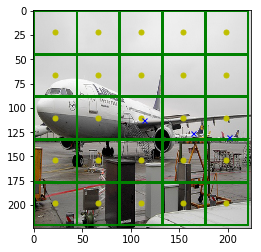

In [14]:
img = imread('../../../VOCdevkit/images/'+'000033.jpg')
visualize_grid_with_gt(img=img, grid_size=(5, 5), y_vector=y_train[3], img_resize=(224, 224))

### testing the method with vanilla vgg16

In [15]:
from keras.models import load_model, model_from_json
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, GlobalAveragePooling2D, Dropout, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

Using TensorFlow backend.


In [16]:
model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [55]:
x = model.output
x = Conv2D(512, (3, 3), padding='same', activation='relu', name='bbox_1')(x)
x = Conv2D(512, (3, 3), padding='same', activation='relu', name='bbox_2')(x)
x = Conv2D(512, (3, 3), padding='valid', activation='relu', name='bbox_3')(x)
output = Conv2D(5, (1, 1), padding='same', name='grid', activation='relu')(x)
Det_model = Model(inputs=model.input, outputs=output)

In [56]:
for layer in model.layers:
    layer.trainable = False
Det_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
import tensorflow as tf

In [97]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]

    logits = tf.nn.sigmoid(y_pred_obj)
    obj_loss = tf.losses.sigmoid_cross_entropy(y_train_obj, logits)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    
    
    bbox_mse = tf.losses.mean_squared_error(bbox_true, bbox_pred)
    final_loss = obj_loss + bbox_mse
    
    return final_loss

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    logits = K.sigmoid(y_pred_obj)
    obj_loss = K.binary_crossentropy(y_train_obj, logits)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [11]:
def custom_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]

    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    final_loss = obj_loss + bbox_mse
    
    return final_loss, obj_loss, bbox_mse

def obj_loss(y_true, y_pred):
    y_train_obj = y_true[:, :, :, 0]
    y_pred_obj = y_pred[:, :, :, 0]
    obj_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train_obj, logits=y_pred_obj)
    
    return obj_loss

def bbox_loss(y_true, y_pred):
    bbox_true = y_true[:, :, :, 1:]
    bbox_pred = y_pred[:, :, :, 1:]
    bbox_mse = tf.losses.mean_squared_error(labels=bbox_true, predictions=bbox_pred)
    
    return bbox_mse

In [50]:
def IOU(y_true, y_pred):
    
    
    true_objects_mask = tf.equal(y_true[:, :, :, 0], 1)

    true_objects_inputs = tf.boolean_mask(y_true, true_objects_mask)

    pred_objects = tf.boolean_mask(y_pred, true_objects_mask)

    y_true = true_objects_inputs
    y_pred = pred_objects
        
    xmin_gt, xmin_pred =  y_true[:,1], y_pred[:,1]
    ymin_gt, ymin_pred =  y_true[:,2], y_pred[:,2]
    xmax_gt, xmax_pred =  y_true[:,3], y_pred[:,3]
    ymax_gt, ymax_pred =  y_true[:,4], y_pred[:,4]


    max_cords_x = tf.maximum(xmin_gt, xmin_pred)
    max_cords_y = tf.maximum(ymin_gt, ymin_pred)

    min_cords_x = tf.minimum(xmax_gt, xmax_pred)
    min_cords_y = tf.minimum(ymax_gt, ymax_pred)

    intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))

    gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
    pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

    union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

    iou = tf.divide(intersect_area, union_area)

    mean_iou = tf.reduce_mean(iou)

    return mean_iou

In [41]:
def new_loss(y_train, y_pred):
    
    #getting the boolean indices of where the objects are present
    true_objects_mask = tf.equal(y_train[:, :, :, 0], 1)
    
    #getting the inputs where only objects are present (ie conf, xmin, ymin, xmax, ymax)
    #true_object_inputs = y_train[true_objects_mask] # numpy equivalent
    # tensorflow equivalent of above expression
    true_objects_inputs = tf.boolean_mask(y_train, true_objects_mask)
    
    
    #getting the network preds for respective locations
    #pred_objects = y_pred[true_objects_mask] # numpy equivalent
    pred_objects = tf.boolean_mask(y_pred, tf.convert_to_tensor(true_objects_mask))
    
    #similarly getting boolean indices where there are no objects
    no_objects_mask = tf.equal(y_train[:, :, :, 0], 0)
    
    #similarly getting the inputs where there no objects basically (0, 0, 0, 0, 0)
    #no_objects_inputs = y_train[no_objects_mask] # numpy equivalent
    no_objects_inputs = tf.boolean_mask(y_train, no_objects_mask)
    
    #getting the network preds for no objs
    #pred_no_objects = y_pred[no_objects_mask] # numpy equivalent
    pred_no_objects = tf.boolean_mask(y_pred, no_objects_mask)
    

    no_object_loss = tf.losses.mean_squared_error(no_objects_inputs, pred_no_objects, weights=0.5)
    
    loss_object = tf.losses.mean_squared_error(true_objects_inputs, pred_objects, weights=5)
    
    loss = loss_object + no_object_loss
    
    return loss

In [175]:
mask = y_train[:, :, :, 0] == 1

K.eval(tf.boolean_mask(y_train, mask))

array([[  1,  86, 132, 137, 224],
       [  1,  41,  25,  86, 224],
       [  1,   0, 165,  12, 197],
       [  1, 203, 165, 224, 188],
       [  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [181]:
y_train[:, :, :, 0] == 1

array([[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False,  True, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False,  True, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [ True, False, False, False,  True]],

       [[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False,  True,  True,  True],
        [False, False, False, False, False],
        [False, False, False, False, False]]], dtype=bool)

In [98]:
Det_model.compile(optimizer='rmsprop', loss=custom_loss, metrics=[obj_loss, bbox_loss, IOU])

In [57]:
Det_model.compile(optimizer='rmsprop', loss=[new_loss], metrics=[IOU])

In [58]:
Det_model.fit_generator(training_generator, 26688 // 4, epochs=3 ,validation_data=validation_generator, validation_steps=400//4)

B:\tookits\Anaconda3\envs\DL\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
3971/6672 [================>.............] - ETA: 21:17 - loss: 10574.3332 - IOU: 0.2489

KeyboardInterrupt: 

In [25]:
preds = Det_model.predict(x_train)

In [34]:
test_loss = custom_loss(tf.cast(y_train, tf.float32), preds)

In [42]:
new_loss(y_train, preds)

<tf.Tensor 'add_7:0' shape=() dtype=float32>

In [52]:
K.eval(IOU(y_train, preds))

TypeError: Input 'y' of 'Maximum' Op has type float32 that does not match type int32 of argument 'x'.

In [49]:
y_train[y_train[:, :, :, 0] == 1][:, 1:]

array([[ 86, 132, 137, 224],
       [ 41,  25,  86, 224],
       [  0, 165,  12, 197],
       [203, 165, 224, 188],
       [  4,  65, 223, 160],
       [145, 115, 184, 136],
       [188, 122, 215, 138]])

#### excellent indexing my way to get to know bboxes

In [163]:
y_train[3, (y_train[3, :, :,0] == 1)]

array([[  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [152]:
y_train[3, (y_train[3, :, :, 0] == 0)]

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [157]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_objects_mask.shape

(4, 5, 5)

In [162]:
y_train[true_objects_mask]

array([[  1,  86, 132, 137, 224],
       [  1,  41,  25,  86, 224],
       [  1,   0, 165,  12, 197],
       [  1, 203, 165, 224, 188],
       [  1,   4,  65, 223, 160],
       [  1, 145, 115, 184, 136],
       [  1, 188, 122, 215, 138]])

In [ ]:
true_objects_mask = (y_train[:, :, :, 0] == 1)
true_object_inputs = y_train[true_objects_mask]
no_objects_mask = (y_train[:, :, :, 0] == 0)
no_objects_inputs = y_train[no_objects_mask]
object_presence_input = true_object_inputs[]

#### end of excellent bboxes ----------------------------------

In [139]:
y_train[3, :, :,]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,   4,  65, 223, 160],
        [  1, 145, 115, 184, 136],
        [  1, 188, 122, 215, 138]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [117]:
y_train[:, :, :, 0], y_train[:, :, :, 1:]

ValueError: operands could not be broadcast together with shapes (4,5,5) (4,5,5,4) 

In [100]:
y_train[:, :, :, 0] , preds[:, :, :, 0]

(array([[[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [1, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]]),
 array([[[ 0.42867598,  0.35086715,  0.36378124,  0.44020969,  0.27385515],
         [ 0.36352858,  0.30997095,  0.27112961,  0.29356119,  0.2511214 ],
         [ 0.39785787,  0.41767052,  0.42296398,  0.45114487,  0.49524561],
         [ 0.49022552,  0.36892691,  0.5450815 ,  0.47621793,  0.47110999],
         [ 0.41960067,  0.21940452,  0.42835286,  0.48870707,  0.33372861]],
 
        [[ 0.32878578,  0.20636937,  0.40615219,  0.37054703,  0.36474374],
         

In [88]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.90204424

In [101]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

0.99500221

In [106]:
K.eval(tf.losses.mean_squared_error(y_train[:, :, :, 1:], preds[:, :, :, 1:]))

1637.3862

In [ ]:
K.eval(tf.losses.sigmoid_cross_entropy(y_train[:, :, :, 0],tf.nn.sigmoid(preds[:,:,:,0])))

In [90]:
K.eval(obj_loss(tf.cast(y_train, tf.float32), preds))

array([[[ 0.53859133,  0.51714879,  0.54043227,  0.5464685 ,  0.64806491],
        [ 0.58427513,  0.56883425,  0.53052199,  0.56055307,  0.56320405],
        [ 0.57744271,  0.55141258,  0.51703477,  0.48698473,  0.55709988],
        [ 0.51439691,  0.50974256,  0.52287447,  0.56566709,  0.62095225],
        [ 0.49376696,  0.56390315,  0.85689807,  0.52101743,  0.5718323 ]],

       [[ 0.50787371,  0.48642069,  0.47709545,  0.60087919,  0.59825581],
        [ 0.41038316,  0.42545384,  0.49284297,  0.53017271,  0.58465898],
        [ 0.47485501,  0.92320013,  0.55151623,  0.58343863,  0.60649961],
        [ 0.60665196,  0.58281565,  0.57652968,  0.59013504,  0.62048614],
        [ 0.66512483,  0.66780126,  0.68053353,  0.6591273 ,  0.65778345]],

       [[ 0.55384219,  0.59769475,  0.62833428,  0.66913176,  0.70161736],
        [ 0.56257105,  0.58055651,  0.62696242,  0.62081492,  0.66759998],
        [ 0.54214835,  0.57442898,  0.54021269,  0.55123687,  0.61313766],
        [ 0.51506382,

In [86]:
K.eval(tf.round(tf.nn.sigmoid(preds[:,:,:,0]))) == np.round(sig_out, 0)

array([[[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]],

       [[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True]]], dtype=bool)

In [85]:
np.round(sig_out, 0)

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]], dtype=float32)

In [49]:
Det_model.compile(optimizer='rmsprop', loss=obj_loss)

In [25]:
len(final_parition['train']), len(final_parition['val'])

(26688, 400)

In [50]:
Det_model.fit_generator(training_generator, 26688 // 4, epochs=3 ,validation_data=validation_generator, validation_steps=400//4)

Epoch 1/3
  37/6672 [..............................] - ETA: 42:00 - loss: -276254.4040

KeyboardInterrupt: 

In [21]:
y_train[:, ].shape

(16, 5, 5)

In [33]:
test = y_train[1]

In [30]:
test[:, :, 1].shape

(5, 5)

In [49]:
test

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [55]:
test[:, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

In [42]:
test[]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  1,  38,  32,  83,  97],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  1,   1,  50,  81, 223],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 120,  67, 224, 210],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [58]:
y_pred = np.zeros((16, 5, 5))

In [59]:
y_pred

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 

In [22]:
y_train[:, :, :, 0]

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0],
        [1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0],
        [0, 0, 1, 1, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0,

In [25]:
y_train[:, :, :, 1:].shape

(16, 5, 5, 4)

In [57]:
np.argmax(y_train[0, :, :, 0], axis=())

array([0, 0, 2, 0, 0], dtype=int64)

In [60]:
y_train[1, :, :, 0]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0]])

#### code snippet for the IOU

In [68]:
xmin_gt, xmin_pred =  y_train[:, :, :, 0], y_pred[:, :, :, 0]
ymin_gt, ymin_pred =  y_train[:, :, :, 1], y_pred[:, :, :, 1]
xmax_gt, xmax_pred =  y_train[:, :, :, 2], y_pred[:, :, :, 2]
ymax_gt, ymax_pred =  y_train[:, :, :, 3], y_pred[:, :, :, 3]


max_cords_x = tf.maximum(xmin_gt, xmin_pred)
max_cords_y = tf.maximum(ymin_gt, ymin_pred)

min_cords_x = tf.minimum(xmax_gt, xmax_pred)
min_cords_y = tf.minimum(ymax_gt, ymax_pred)

intersect_area = tf.multiply(tf.add(tf.subtract(min_cords_x, max_cords_x), 1), tf.add(tf.subtract(min_cords_y, max_cords_y),1))

gt_areas = tf.multiply(tf.add(tf.subtract(xmax_gt, xmin_gt), 1), tf.add(tf.subtract(ymax_gt, ymin_gt), 1))
pred_areas = tf.multiply(tf.add(tf.subtract(xmax_pred, xmin_pred), 1), tf.add(tf.subtract(ymax_pred, ymin_pred), 1))

union_area = tf.subtract(tf.add(gt_areas, pred_areas), intersect_area)

iou = tf.divide(intersect_area / union_area)

In [70]:
def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

In [71]:
def sigmoid_cross_entropy(true, pred):
    return - np.sum(np.multiply(true, np.log(pred)))
    